In [137]:
import numpy as np
import networkx as nx
import typing
import random as rn

class BAGraph:
    def __init__(self, 
                 m: int):
        self._m = m
        self._graph = nx.DiGraph()
        self._graph.add_nodes_from(range(m))
    
    @property
    def graph(self):
        return self._graph
    
    @property
    def m(self):
        return self._m
    
    @property
    def nodes(self):
        return self._graph.nodes
    
    @property
    def edges(self):
        return self._graph.edges
    
    """
    @property
    def timearrivals(self):
        time_arrivals = [0]*self.m + list(range(1, len(self.nodes) - self.m + 1))
        return {i: time_arrivals[i] for i in range(len(self.nodes))}"""
    @property
    def time_of_arrivals(self):
        time_arrivals = list(range(len(self.nodes)))
        return {i: time_arrivals[i] for i in range(len(self.nodes))}
    
    @property
    def adjacency_matrix(self):
        return nx.adjacency_matrix(self._graph).toarray()
    
    @property                                                                                           #PAGERANK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def pagerank(self, 
                 alpha:float = 0.85
                 )->dict:
        """
        Returns the page rank value of each node in `dict` format
        """
        return nx.pagerank(self.graph, alpha = alpha)  
    
    @property                                                                                           #EIGENVECTOR!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!4
    def eigenvector_centrality(self):
         return nx.eigenvector_centrality(self.graph, max_iter=1000)

    
    @property                                                                                           #INDEG!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def indegrees(self):
        return self.graph.in_degree
    
    @m.setter
    def m(self, 
          m: int):
        self._m = m

    """"
    def eigenvector_centrality(self):
        return nx.eigenvector_centrality_numpy(self.graph)
        return nx.algorithms.centrality.eigenvector_centrality(self.graph)
        """

    def calcProbabilities(self) -> np.ndarray:
        """
        Calculates the attachment probabilities for each node
        when the new node comes in.
        """
        if len(self.edges) == 0:
            return np.ones(len(self.nodes))/len(self.nodes)
        sum_degree = 2*len(self.graph.edges)
        return np.array(list(dict(self.graph.degree).values())) / sum_degree
     
    def addNode(self):
        """
        Adds a new node to the graph
        """
        probs = self.calcProbabilities()
        chosen_nodes = np.random.choice(list(self.graph.nodes),
                                       self._m,
                                       replace = False,
                                       p = probs)
        self.graph.add_node(len(self._graph.nodes))
        for node in chosen_nodes:
            self.graph.add_edge(list(self.graph.nodes)[-1],node)
            
    def buildGraph(self, 
                   n: int):
        """
        Builds the Barabasi-Albert graph with `n` new nodes
        """
        for _ in range(n):
            self.addNode()

In [ ]:
import matplotlib.pyplot as plt


G = BAGraph(2)   #maga a class object
G.buildGraph(3)
print(G.nodes)
print("pagerank:")
print(G.pagerank)
print("eigenvec cent:")
print(G.eigenvector_centrality)
print(G.time_of_arrivals)
print(G.pagerank[2])
nx.draw(G.graph, with_labels=True, labels={node: str(node) for node in G.nodes})





In [121]:
"""
import matplotlib.pyplot as plt   #m = 1

k = 200
m = 1
nodes = 300
time_of_arriv_vec = np.zeros(k)
pagerank_scores_vec = np.zeros(k)
eigenvector_centrality_vec = np.zeros(k)
indegrees_vec = np.zeros(k)

for i in range(k):   
    g = BAGraph(m)
    g.buildGraph(nodes)
    U = rn.choice(list(range(nodes))) 
    time_of_arriv_vec[i] = g.time_of_arrivals[U]
    pagerank_scores_vec[i] = g.pagerank[U]
    eigenvector_centrality_vec[i] = g.eigenvector_centrality[U]
    indegrees_vec[i] = g.indegrees[U]


corr_mtx1 = np.corrcoef(time_of_arriv_vec, pagerank_scores_vec)
corr_coeff1 = corr_mtx1[0, 1]

corr_mtx2 = np.corrcoef(time_of_arriv_vec, eigenvector_centrality_vec)
corr_coeff2 = corr_mtx2[0, 1]

corr_mtx3 = np.corrcoef(time_of_arriv_vec, indegrees_vec)
corr_coeff3 = corr_mtx3[0, 1]

corr_mtx4 = np.corrcoef(indegrees_vec,eigenvector_centrality_vec)
corr_coeff4 = corr_mtx4[0, 1]

corr_mtx5 = np.corrcoef(pagerank_scores_vec,eigenvector_centrality_vec)
corr_coeff5 = corr_mtx5[0, 1]

corr_mtx6 = np.corrcoef(pagerank_scores_vec,indegrees_vec)
corr_coeff6 = corr_mtx6[0, 1]






print(f"correlation coefficient:{corr_coeff1}")  
plt.scatter(time_of_arriv_vec,pagerank_scores_vec)
plt.xlabel('Arrival Times')
plt.ylabel('PageRank Scores')
plt.show()

print(f"correlation coefficient:{corr_coeff2}") 
plt.scatter(time_of_arriv_vec,eigenvector_centrality_vec)
plt.xlabel('Arrival Times')
plt.ylabel('Eigenvector Centrality')
plt.show()

print(f"correlation coefficient:{corr_coeff3}") 
plt.scatter(time_of_arriv_vec,indegrees_vec)
plt.xlabel('Arrival Times')
plt.ylabel('Indegrees')
plt.show()

print(f"correlation coefficient:{corr_coeff4}") 
plt.scatter(indegrees_vec,eigenvector_centrality_vec)
plt.xlabel('indegrees')
plt.ylabel('eigenvec')
plt.show()

print(f"correlation coefficient:{corr_coeff5}") 
plt.scatter(pagerank_scores_vec,eigenvector_centrality_vec)
plt.xlabel('pagerank')
plt.ylabel('eigenvec')
plt.show()


print(f"correlation coefficient:{corr_coeff6}") 
plt.scatter(pagerank_scores_vec,indegrees_vec)
plt.xlabel('pagerank')
plt.ylabel('indeg')
plt.show()
"""


'\nimport matplotlib.pyplot as plt   #m = 1\n\nk = 200\nm = 1\nnodes = 300\ntime_of_arriv_vec = np.zeros(k)\npagerank_scores_vec = np.zeros(k)\neigenvector_centrality_vec = np.zeros(k)\nindegrees_vec = np.zeros(k)\n\nfor i in range(k):   \n    g = BAGraph(m)\n    g.buildGraph(nodes)\n    U = rn.choice(list(range(nodes))) \n    time_of_arriv_vec[i] = g.time_of_arrivals[U]\n    pagerank_scores_vec[i] = g.pagerank[U]\n    eigenvector_centrality_vec[i] = g.eigenvector_centrality[U]\n    indegrees_vec[i] = g.indegrees[U]\n\n\ncorr_mtx1 = np.corrcoef(time_of_arriv_vec, pagerank_scores_vec)\ncorr_coeff1 = corr_mtx1[0, 1]\n\ncorr_mtx2 = np.corrcoef(time_of_arriv_vec, eigenvector_centrality_vec)\ncorr_coeff2 = corr_mtx2[0, 1]\n\ncorr_mtx3 = np.corrcoef(time_of_arriv_vec, indegrees_vec)\ncorr_coeff3 = corr_mtx3[0, 1]\n\ncorr_mtx4 = np.corrcoef(indegrees_vec,eigenvector_centrality_vec)\ncorr_coeff4 = corr_mtx4[0, 1]\n\ncorr_mtx5 = np.corrcoef(pagerank_scores_vec,eigenvector_centrality_vec)\ncorr_

In [120]:
"""
import matplotlib.pyplot as plt

k = 50
m = 4
nodes = 100
time_of_arriv_vec = np.zeros(k)
pagerank_scores_vec = np.zeros(k)
eigenvector_centrality_vec = np.zeros(k)
indegrees_vec = np.zeros(k)

for i in range(k):   
    g = BAGraph(m)
    g.buildGraph(nodes)
    U = rn.choice(list(range(nodes))) 
    time_of_arriv_vec[i] = g.time_of_arrivals[U]
    pagerank_scores_vec[i] = g.pagerank[U]
    eigenvector_centrality_vec[i] = g.eigenvector_centrality[U]
    indegrees_vec[i] = g.indegrees[U]


corr_mtx1 = np.corrcoef(time_of_arriv_vec, pagerank_scores_vec)
corr_coeff1 = corr_mtx1[0, 1]

corr_mtx2 = np.corrcoef(time_of_arriv_vec, eigenvector_centrality_vec)
corr_coeff2 = corr_mtx2[0, 1]

corr_mtx3 = np.corrcoef(time_of_arriv_vec, indegrees_vec)
corr_coeff3 = corr_mtx3[0, 1]

corr_mtx4 = np.corrcoef(indegrees_vec,eigenvector_centrality_vec)
corr_coeff4 = corr_mtx4[0, 1]

corr_mtx5 = np.corrcoef(pagerank_scores_vec,eigenvector_centrality_vec)
corr_coeff5 = corr_mtx5[0, 1]

corr_mtx6 = np.corrcoef(pagerank_scores_vec,indegrees_vec)
corr_coeff6 = corr_mtx6[0, 1]






print(f"correlation coefficient:{corr_coeff1}")  
plt.scatter(time_of_arriv_vec,pagerank_scores_vec)
plt.xlabel('Arrival Times')
plt.ylabel('PageRank Scores')
plt.show()

print(f"correlation coefficient:{corr_coeff2}") 
plt.scatter(time_of_arriv_vec,eigenvector_centrality_vec)
plt.xlabel('Arrival Times')
plt.ylabel('Eigenvector Centrality')
plt.show()

print(f"correlation coefficient:{corr_coeff3}") 
plt.scatter(time_of_arriv_vec,indegrees_vec)
plt.xlabel('Arrival Times')
plt.ylabel('Indegrees')
plt.show()

print(f"correlation coefficient:{corr_coeff4}") 
plt.scatter(indegrees_vec,eigenvector_centrality_vec)
plt.xlabel('indegrees')
plt.ylabel('eigenvec')
plt.show()

print(f"correlation coefficient:{corr_coeff5}") 
plt.scatter(pagerank_scores_vec,eigenvector_centrality_vec)
plt.xlabel('pagerank')
plt.ylabel('eigenvec')
plt.show()


print(f"correlation coefficient:{corr_coeff6}") 
plt.scatter(pagerank_scores_vec,indegrees_vec)
plt.xlabel('pagerank')
plt.ylabel('indeg')
plt.show()
"""






'\nimport matplotlib.pyplot as plt\n\nk = 50\nm = 4\nnodes = 100\ntime_of_arriv_vec = np.zeros(k)\npagerank_scores_vec = np.zeros(k)\neigenvector_centrality_vec = np.zeros(k)\nindegrees_vec = np.zeros(k)\n\nfor i in range(k):   \n    g = BAGraph(m)\n    g.buildGraph(nodes)\n    U = rn.choice(list(range(nodes))) \n    time_of_arriv_vec[i] = g.time_of_arrivals[U]\n    pagerank_scores_vec[i] = g.pagerank[U]\n    eigenvector_centrality_vec[i] = g.eigenvector_centrality[U]\n    indegrees_vec[i] = g.indegrees[U]\n\n\ncorr_mtx1 = np.corrcoef(time_of_arriv_vec, pagerank_scores_vec)\ncorr_coeff1 = corr_mtx1[0, 1]\n\ncorr_mtx2 = np.corrcoef(time_of_arriv_vec, eigenvector_centrality_vec)\ncorr_coeff2 = corr_mtx2[0, 1]\n\ncorr_mtx3 = np.corrcoef(time_of_arriv_vec, indegrees_vec)\ncorr_coeff3 = corr_mtx3[0, 1]\n\ncorr_mtx4 = np.corrcoef(indegrees_vec,eigenvector_centrality_vec)\ncorr_coeff4 = corr_mtx4[0, 1]\n\ncorr_mtx5 = np.corrcoef(pagerank_scores_vec,eigenvector_centrality_vec)\ncorr_coeff5 = c

In [190]:
import matplotlib.pyplot as plt   #m = 1
m = 1
iter = 1000
number_of_nodes = np.array([10,50,100,150,200,250,300,350,400,450,500, 550,600,650,700,750,800,850,900,950,1000])

time_of_arriv_vectors = [np.zeros(iter) for x in range(len(number_of_nodes))]
pagerank_scores_vectors = [np.zeros(iter) for x in range(len(number_of_nodes))]
eigenvector_centrality_vectors = [np.zeros(iter) for x in range(len(number_of_nodes))]
indegrees_vectors = [np.zeros(iter) for x in range(len(number_of_nodes))]

for current_number_of_nodes in range(len(number_of_nodes)):
    for i in range(iter):   
        g = BAGraph(m)
        g.buildGraph(number_of_nodes[current_number_of_nodes])
        U = rn.choice(list(range(number_of_nodes[current_number_of_nodes]))) 
        time_of_arriv_vectors[current_number_of_nodes][i] = g.time_of_arrivals[U]
        pagerank_scores_vectors[current_number_of_nodes][i] = g.pagerank[U]
        eigenvector_centrality_vectors[current_number_of_nodes][i] = g.eigenvector_centrality[U]
        indegrees_vectors[current_number_of_nodes][i] = g.indegrees[U]

In [191]:
corr_time_pagerank_vec = np.zeros(len(number_of_nodes))
corr_time_eigenvec_vec = np.zeros(len(number_of_nodes))
corr_time_indeg_vec = np.zeros(len(number_of_nodes))
corr_indeg_eigenvec_vec = np.zeros(len(number_of_nodes))
corr_pagerank_eigenvec_vec = np.zeros(len(number_of_nodes))
corr_pagerank_indeg_vec = np.zeros(len(number_of_nodes))



for current_number_of_nodes in range(len(number_of_nodes)) :
    corr_time_pagerank_vec[current_number_of_nodes] = np.corrcoef(time_of_arriv_vectors[current_number_of_nodes], pagerank_scores_vectors[current_number_of_nodes])[0, 1]     #this is the empirical correlation matrix's 0th row' 1st element, so the correlation between the two samples

    corr_time_eigenvec_vec[current_number_of_nodes] = np.corrcoef(time_of_arriv_vectors[current_number_of_nodes], eigenvector_centrality_vectors[current_number_of_nodes])[0, 1]

    corr_time_indeg_vec[current_number_of_nodes] = np.corrcoef(time_of_arriv_vectors[current_number_of_nodes], indegrees_vectors[current_number_of_nodes])[0, 1]

    corr_indeg_eigenvec_vec[current_number_of_nodes] = np.corrcoef(indegrees_vectors[current_number_of_nodes],eigenvector_centrality_vectors[current_number_of_nodes])[0, 1]

    corr_pagerank_eigenvec_vec[current_number_of_nodes] = np.corrcoef(pagerank_scores_vectors[current_number_of_nodes],eigenvector_centrality_vectors[current_number_of_nodes])[0, 1]

    corr_pagerank_indeg_vec[current_number_of_nodes] = np.corrcoef(pagerank_scores_vectors[current_number_of_nodes],indegrees_vectors[current_number_of_nodes])[0, 1]


In [192]:
from matplotlib.cm import get_cmap

cmap = get_cmap('tab10')
colors = cmap(np.linspace(0,1,len(number_of_nodes)))

C:\Users\Bori\AppData\Local\Temp\ipykernel_24300\3877333067.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


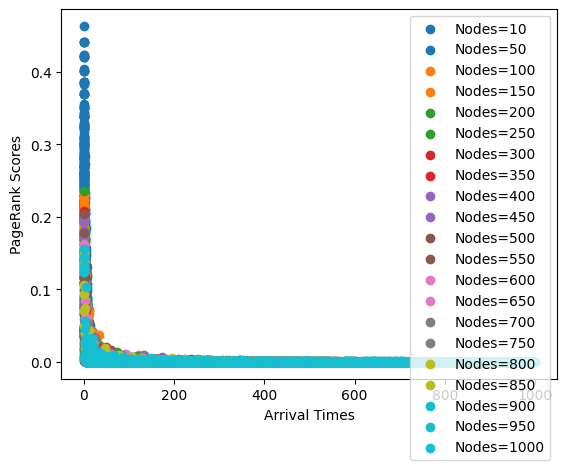

In [193]:
for current_number_of_nodes in range(len(number_of_nodes)):
    plt.scatter(time_of_arriv_vectors[current_number_of_nodes], pagerank_scores_vectors[current_number_of_nodes], label=f'Nodes={number_of_nodes[current_number_of_nodes]}', color=colors[current_number_of_nodes])

plt.xlabel('Arrival Times')
plt.ylabel('PageRank Scores')
plt.legend()
plt.show()


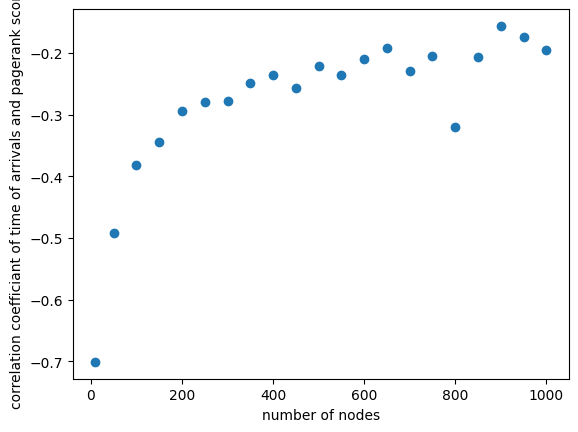

In [194]:
plt.scatter(number_of_nodes,corr_time_pagerank_vec)
plt.xlabel("number of nodes")
plt.ylabel("correlation coefficiant of time of arrivals and pagerank scores")
plt.show()

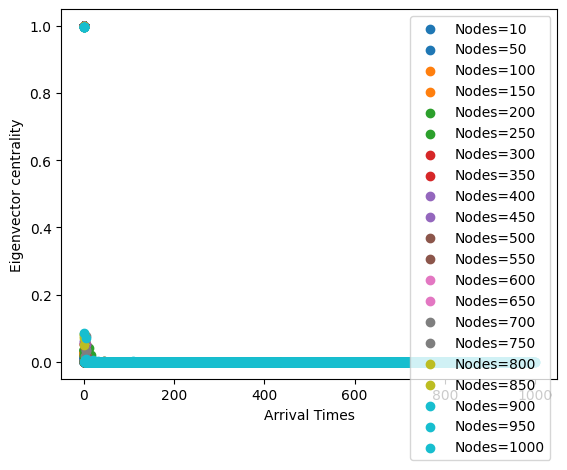

In [195]:
for current_number_of_nodes in range(len(number_of_nodes)):
    plt.scatter(time_of_arriv_vectors[current_number_of_nodes], eigenvector_centrality_vectors[current_number_of_nodes], label=f'Nodes={number_of_nodes[current_number_of_nodes]}', color=colors[current_number_of_nodes])

plt.xlabel('Arrival Times')
plt.ylabel('Eigenvector centrality')
plt.legend()
plt.show()

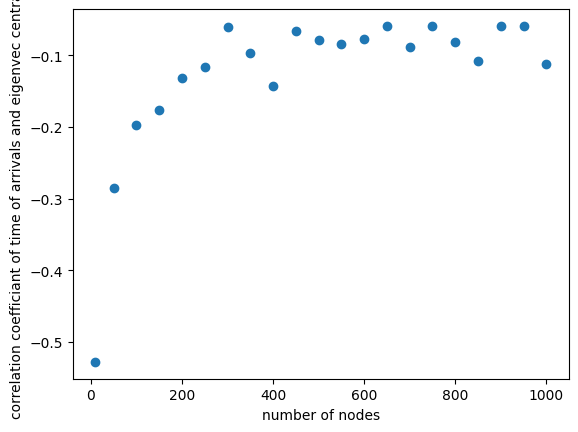

In [196]:
plt.scatter(number_of_nodes,corr_time_eigenvec_vec)
plt.xlabel("number of nodes")
plt.ylabel("correlation coefficiant of time of arrivals and eigenvec centrality")
plt.show()

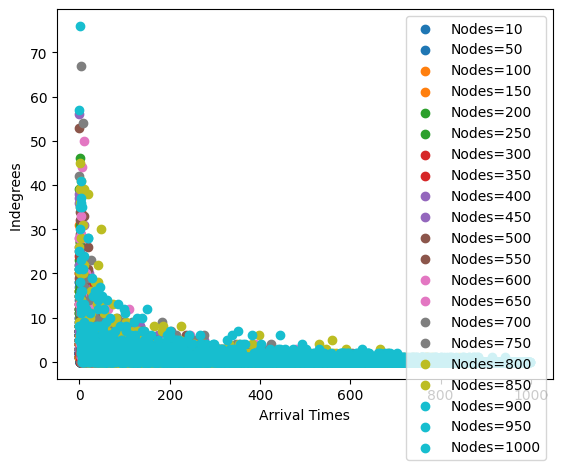

In [197]:
for current_number_of_nodes in range(len(number_of_nodes)):
    plt.scatter(time_of_arriv_vectors[current_number_of_nodes], indegrees_vectors[current_number_of_nodes], label=f'Nodes={number_of_nodes[current_number_of_nodes]}', color=colors[current_number_of_nodes])

plt.xlabel('Arrival Times')
plt.ylabel('Indegrees ')
plt.legend()
plt.show()

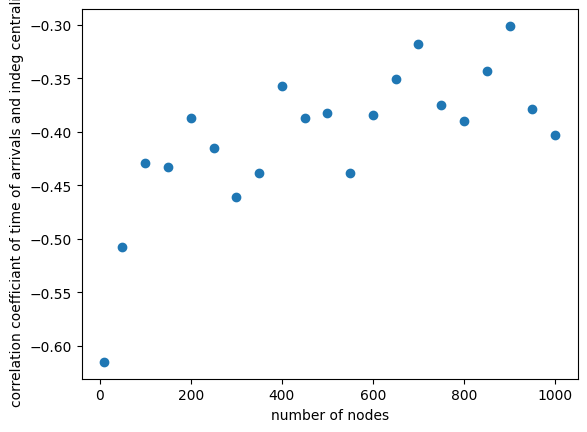

In [198]:
plt.scatter(number_of_nodes,corr_time_indeg_vec)
plt.xlabel("number of nodes")
plt.ylabel("correlation coefficiant of time of arrivals and indeg centrality")
plt.show()

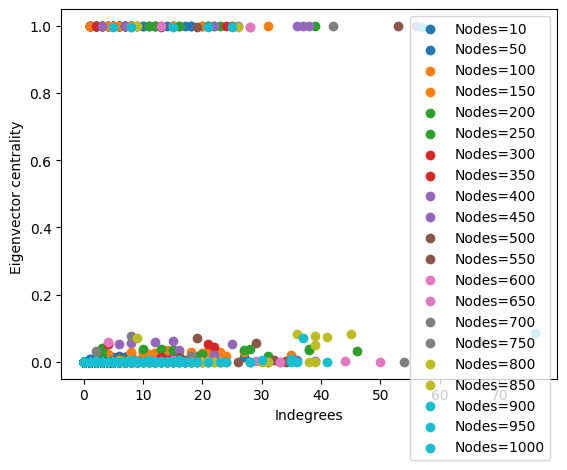

In [199]:
for current_number_of_nodes in range(len(number_of_nodes)):
    plt.scatter(indegrees_vectors[current_number_of_nodes], eigenvector_centrality_vectors[current_number_of_nodes], label=f'Nodes={number_of_nodes[current_number_of_nodes]}', color=colors[current_number_of_nodes])

plt.xlabel('Indegrees')
plt.ylabel('Eigenvector centrality ')
plt.legend()
plt.show()

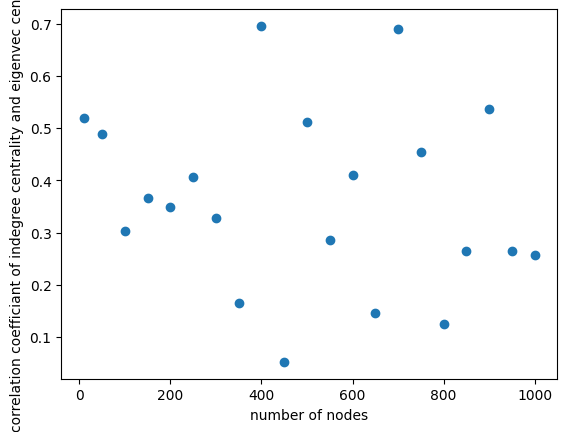

In [200]:
plt.scatter(number_of_nodes,corr_indeg_eigenvec_vec)
plt.xlabel("number of nodes")
plt.ylabel("correlation coefficiant of indegree centrality and eigenvec centrality")
plt.show()

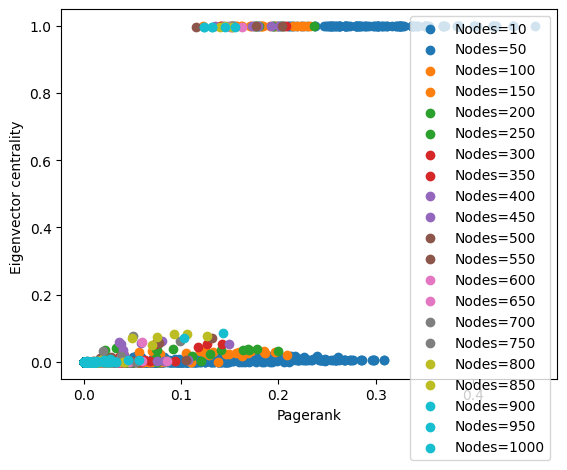

In [201]:
for current_number_of_nodes in range(len(number_of_nodes)):
    plt.scatter(pagerank_scores_vectors[current_number_of_nodes], eigenvector_centrality_vectors[current_number_of_nodes], label=f'Nodes={number_of_nodes[current_number_of_nodes]}', color=colors[current_number_of_nodes])

plt.xlabel('Pagerank')
plt.ylabel('Eigenvector centrality ')
plt.legend()
plt.show()

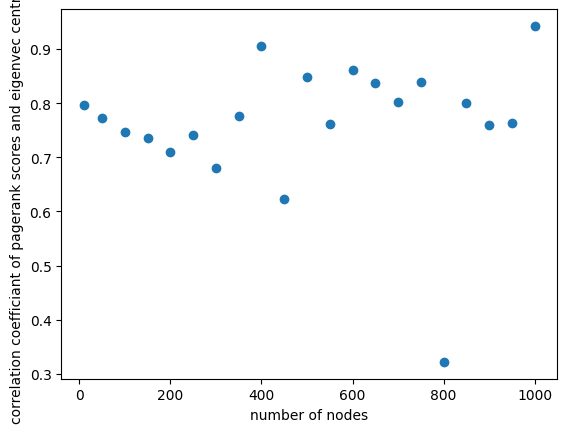

In [202]:
plt.scatter(number_of_nodes,corr_pagerank_eigenvec_vec)
plt.xlabel("number of nodes")
plt.ylabel("correlation coefficiant of pagerank scores and eigenvec centrality")
plt.show()

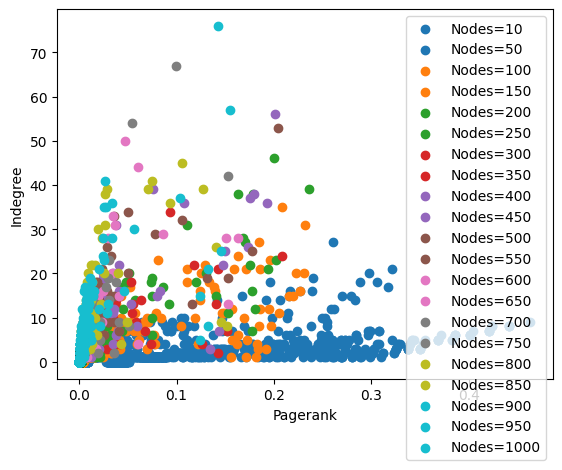

In [203]:
for current_number_of_nodes in range(len(number_of_nodes)):
    plt.scatter(pagerank_scores_vectors[current_number_of_nodes], indegrees_vectors[current_number_of_nodes], label=f'Nodes={number_of_nodes[current_number_of_nodes]}', color=colors[current_number_of_nodes])

plt.xlabel('Pagerank')
plt.ylabel('Indegree')
plt.legend()
plt.show()

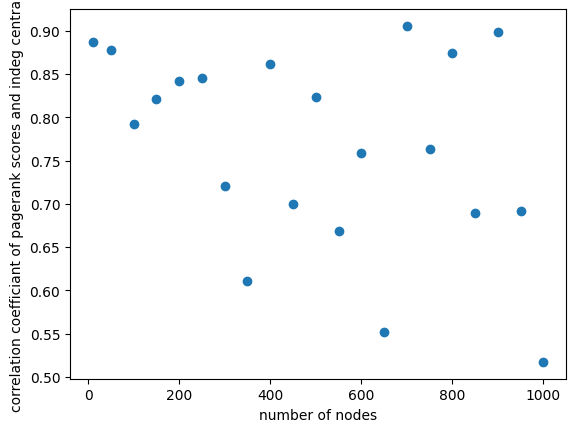

In [204]:
plt.scatter(number_of_nodes,corr_pagerank_indeg_vec)
plt.xlabel("number of nodes")
plt.ylabel("correlation coefficiant of pagerank scores and indeg centrality")
plt.show()